# DeOldify using OpenVINO

DeOldify is an open-source deep learning project, that uses generative adversarial networks (GANs) to colorize and restore old black and white images and videos. The project is built using PyTorch and utilizes a deep neural network architecture to analyze and add color to grayscale images and videos.  More details about its realization can be found in original model [repository](https://github.com/jantic/DeOldify).

This tutorial demonstrates how to convert and run the pytorch model for DeOldify with OpenVino.

There are currently three models available: one to produce stable color results on images, one to produce artistic colors on an image and one to convert a video (More details on this is available on the original [repo link](https://github.com/jantic/DeOldify).

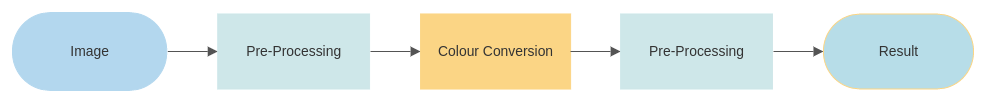

## **Validate Pytorch model**

## **Prerequisites**

In [ ]:
import sys
from pathlib import Path
sys.path.append("../utils")
from notebook_utils import download_file as df  # noqa: E402

## Clone the repo

In [ ]:
# Clone DeOldify repo
if not Path('DeOldify').exists():
    !git clone https://github.com/jantic/DeOldify.git
%cd DeOldify

## Install requirements

In [ ]:
!pip install -r requirements.txt
!pip install onnxruntime

## Imports

In [ ]:
import os  # noqa: E402
import re  # noqa: E402
from typing import Union as Un  # noqa: E402
from typing import Tuple  # noqa: E402
import cv2  # noqa: E402
import numpy as np  # noqa: E402
import torch as tr  # noqa: E402
import yt_dlp as youtube_dl  # noqa: E402
from matplotlib import pyplot as plt  # noqa: E402
from openvino.inference_engine import IECore  # noqa: E402
from openvino.runtime import Core, serialize  # noqa: E402
from openvino.tools import mo  # noqa: E402

In [ ]:
import deoldify.generators as gen  # noqa: E402
from deoldify.visualize import get_image_colorizer  # noqa: E402
from deoldify.visualize import get_video_colorizer  # noqa: E402
from deoldify.visualize import show_image_in_notebook  # noqa: E402
from deoldify.visualize import show_video_in_notebook  # noqa: E402

## Helper Function

In [ ]:
def subfolder_check(color_source_path: str):
    """
    Checks creates the specified directory if it doesn't exist.

    Parameters:
        color_source_path: Directory path to check and create.

    Returns:
        None
    """
    if not Path(color_source_path).exists():
        os.mkdir(color_source_path)

## Download pre-trained model weights and run inference

We take user input in the cell below to decide if we want to generate results for an image or a video and also to check whether the model is expected to generate artistic output or not.

In [ ]:
def input_type():
    """
    Determines if input format is image or video
    In case of image input, decides between artistic or stable results

    Returns:
        inputs: A list of two boolean values
    """
    image = "True"  # make this false to load video inference
    artistic = "True"  # make this false to generate stable results
    inputs = [image, artistic]
    return inputs

Based on what we decide, either the pre-trained **ColorizeArtistic_gen.pth** is downloaded using the download_file function provided exclusively by OpenVino Toolkit or **ColorizeStable_gen.pth** is downloaded and for videos, we download the **ColorizeVideo_gen.pth**.

ColorizeArtistic_gen.pth : The model uses a resnet34 backbone on a UNet with an emphasis on depth of layers on the decoder side. This model was trained with 5 critic pretrain/GAN cycle repeats via NoGAN, in addition to the initial generator/critic pretrain/GAN NoGAN training, at 192px. 

ColorizeStable_gen.pth : This model uses a resnet101 backbone on a UNet with an emphasis on width of layers on the decoder side. This model was trained with 3 critic pretrain/GAN cycle repeats via NoGAN, in addition to the initial generator/critic pretrain/GAN NoGAN training, at 192px.

ColorizeVideo_gen.pth : The model is the same as "stable" in terms of architecture, but differs in training. It's trained at 192px, using only the initial generator/critic pretrain/GAN NoGAN training.

In [ ]:
image = input_type()[0]
artistic = input_type()[1]

if image == "True":
    if artistic == "True":
        if not Path('models/ColorizeArtistic_gen.pth').exists():
            URL = "https://data.deepai.org/deoldify/ColorizeArtistic_gen.pth"
            MODEL_DIR = Path("models/")
            df(URL, directory=MODEL_DIR, show_progress=True)
    else:
        if not Path('models/ColorizeStable_gen.pth').exists():
            !wget https://www.dropbox.com/s/axsd2g85uyixaho/ColorizeStable_gen.pth?dl=0 -O ./models/ColorizeStable_gen.pth
else:
    if not Path('models/ColorizeVideo_gen.pth').exists():
        !wget https://data.deepai.org/deoldify/ColorizeVideo_gen.pth -O ./models/ColorizeVideo_gen.pth

Here is a black and white image of a beautiful women and using DeOldify, we will colorize it. But first lets download the image and store it under the test_images directory which is present in our cloned repository for DeOldify. This photo is taken from this [website](https://photo-works.net/how-to-make-picture-black-and-white.php) which converts a color photo to black and white.

In [ ]:
image = input_type()[0]
if image == 'True':
    img_url = "https://tinyurl.com/3nrt3h4p"
    fname = "image.png"
    folder = "test_images"
    df(img_url, fname, folder, show_progress=True, silent=True, timeout=30)
else:
    subfolder_check('video')
    subfolder_check('video/source')
    ydl_opts = {
        'format': 'bestvideo[ext=mp4]+bestaudio[ext=m4a]/mp4',
        'outtmpl': str(Path("video/source/vid.mp4")),
        'retries': 30,
        'fragment-retries': 30
    }
    with youtube_dl.YoutubeDL(ydl_opts) as ydl:
        ydl.download(["https://tinyurl.com/2p884ea7"])

Down in the cells is the part where we load the model and get the colored image or video.

In [ ]:
image = input_type()[0]


def colorise(image):
    if image == "True":
        colorizer = get_image_colorizer(artistic=artistic)
    else:
        colorizer = get_video_colorizer()
    return colorizer

In [ ]:
image = input_type()[0]
cz = colorise(image)

if image == "True":
    # NOTE:  Max is 45 with 11GB video cards. 35 is a good default
    rf = 35  # render_factor
    # U='https://tinyurl.com/3nrt3h4p'
    RP = None  # result path
    F = (20, 20)  # figsize
    U = None  # source_url
    drf = False  # display_render_factor
    P = 'test_images/image.png'  # source_path
    C = True  # compare
    pp = True  # post_process
    W = True  # watermarked

    if U is not None:
        RP = cz.plot_transformed_image_from_url(U, P, RP, F, rf, drf, C, pp, W)
    else:
        RP = cz.plot_transformed_image(P, RP, F, rf, drf, C, pp, W)

    show_image_in_notebook(RP)
else:
    # NOTE:  Max is 44 with 11GB video cards.  21 is a good default
    r_f = 21  # render_factor
#     s_u='https://twitter.com/silentmoviegifs/status/1116751583386034176'
    s_u = None  # source_url
    f_n = 'vid'  # file_name
    f_n_e = f_n + '.mp4'  # file_name_extended
    r_p = None  # result_path

    if s_u is not None:
        r_p = cz.colorize_from_url(s_u, f_n_e, r_f)
    else:
        r_p = cz.colorize_from_file_name(f_n_e, r_f)

    show_video_in_notebook(r_p)

## Convert Pytorch model into onnx format

Before we start converting the pytorch model into onnx format and later into OpenVino IR format, lets define some variables to improve code redability and minimize the number of if statements when switching models.

In [ ]:
image = input_type()[0]
artistic = input_type()[1]


def attributes(image, artistic):
    if image == "True":
        if artistic == "True":
            wt_name = "ColorizeArtistic_gen"
            onnx_path = "models/ColorizeArtistic_deoldify.onnx"
            onnx_name = "ColorizeArtistic_deoldify.onnx"
            xml_name = "models/ColorizeArtistic_deoldify.xml"
            bin_name = "models/ColorizeArtistic_deoldify.bin"
        else:
            wt_name = "ColorizeStable_gen"
            onnx_path = "models/ColorizeStable_deoldify.onnx"
            onnx_name = "ColorizeStable_deoldify.onnx"
            xml_name = "models/ColorizeStable_deoldify.xml"
            bin_name = "models/ColorizeStable_deoldify.bin"
    else:
        wt_name = "ColorizeVideo_gen"
        onnx_path = "models/ColorizeVideo_deoldify.onnx"
        onnx_name = "ColorizeVideo_deoldify.onnx"
        xml_name = "models/ColorizeVideo_deoldify.xml"
        bin_name = "models/ColorizeVideo_deoldify.bin"

    return wt_name, onnx_path, onnx_name, xml_name, bin_name

Below we convert the pytorch model into onnx format.
First we load the pytorch model. We need to remove the spectral normalizations after loading the model as this is an unsupported operator in ONNX and not doing so raises an error while exporting. We define a 192x192 image input size. 

In [ ]:
INPUT_SIZE = 192  # use 576 for better results or 96 if cell fails to run


def refine_network(item: Un[tr.nn.Module, tr.nn.ModuleList, tr.nn.Sequential]):
    """
    Recursively removes spectral normalization from all PyTorch modules.

    It recursively traverses the input PyTorch module and its submodules.
    Spectral normalization stabilizes the training of generative models.
    After training, spectral normalization might be desirable to remove.
    This function removes spectral normalization present in any module.

    Parameters:
        item : The PyTorch module to remove spectral normalization from.

    Returns:
        None
    """
    if isinstance(item, tr.nn.Module):
        try:
            tr.nn.utils.remove_spectral_norm(item)
        except Exception:
            pass
        for child in item.children():
            refine_network(child)

    if isinstance(item, tr.nn.ModuleList):
        for module in item:
            refine_network(module)

    if isinstance(item, tr.nn.Sequential):
        modules = item.children()
        for module in modules:
            refine_network(module)


def export_to_onnx_and_test() -> None:
    """
    Exports the DeOldify network as an ONNX model.

    This function exports the model in ONNX format.
    But 'mv' operation is not supported by torch.onnx.export.
    This function also removes spectral normalization from the model.

    Returns:
        None
    """
    image = input_type()[0]
    artistic = input_type()[1]
    W, onnx_path, onnx_n, xml, bin_name = attributes(image, artistic)
    P = Path("./")

    print("> Load the DeOldify network")
    if image == "True":
        if artistic == "True":
            tr_m = gen.gen_inference_deep(root_folder=P, weights_name=W).model
        else:
            tr_m = gen.gen_inference_wide(root_folder=P, weights_name=W).model
    else:
        tr_m = gen.gen_inference_wide(root_folder=P, weights_name=W).model
    tr_m.eval()

    print("> Set example input to the model for exporting and for testing")
    example_input_t = tr.rand(1, 3, INPUT_SIZE, INPUT_SIZE)

    print("> Export the model as ONNX format")
    refine_network(tr_m)  # 'mv' operation not supported by torch.onnx.export
    tr.onnx.export(
        tr_m,
        example_input_t,
        onnx_path,
        export_params=True,
        opset_version=9,
        do_constant_folding=False,
        input_names=["input"],
        output_names=["output"])


export_to_onnx_and_test()

## Convert onnx model into openvino Ir format

Although the OpenVINO runtime directly supports ONNX models, it may be advantageous to convert them to IR format in order to make use of the OpenVINO optimisation tools and capabilities. To convert a model using OpenVINO Model Optimizer, use the mo.convert model Python function. Instances of the OpenVINO Model class are returned by the function, ready for usage in the Python interface but also capable of being serialised to the OpenVINO IR format for later execution.

In [ ]:
wt_name, onnx_path, onnx_name, xml_name, bin_name = attributes(image, artistic)
model = mo.convert_model(onnx_path)
# serialize model for saving IR
serialize(model, xml_name)

## Run inference from Openvino IR model

Next we set up the environment for deploying an OpenVINO optimized model on a CPU device and obtain information about the model input and output layers. Our process typically begins with preprocessing, then uses OpenVINO model inference and results post-processing to provide a colourized output.

## Image Processing - PreProcessing + PostProcessing

Model input is in accordance with shape [1, 3, 192, 192] in N, C, H, W format, where

N - number of images in batch (batch size)

C - image channels

H - image height

W - image width

The pre_processing function takes an image in the form of a NumPy array as input, resizes it to a specific size using cv2.resize, converts it to a float tensor with pixel values in the range [0, 1], and normalizes pixel values using mean [0.485, 0.456, 0.406] and standard deviation [0.229, 0.224, 0.225]. The final output of the function is a float tensor after preprocessing.

The post_processing function takes the output of a computer vision model in the form of a NumPy array as input, and post-processes it to obtain a coloured image of the same size as that of the input image. The function first normalizes the pixel values using cv2.normalize, scales the pixel values by 255, transposes the dimensions of the array, reverses the order of the channels, and converts the pixel values to unsigned 8-bit integers. The function then resizes the image to the original size of the input image and converts it to RGB format. Finally, the function returns the postprocessed image as a NumPy array.

In [ ]:
def pre_processing(img: np.ndarray, W: int, H: int):
    """
    Preprocess image according to DeOldify input requirements.
    Converts preprocessed image to tensor format.
    Changes data layout from HWC to CHW.

    Converts image in np.array format with unit8 data in [0, 255] range
    to torch.Tensor object with float data in [0, 1] range.
    Normalizes pixel values using mean [0.485, 0.456, 0.406]
    and standard deviation [0.229, 0.224, 0.225].

    Parameters:
      img (np.ndarray): image for preprocessing
      W : Image width that the OpenVino IR model expects
      H : Image height that the OpenVino IR model expects

    Returns:
      final_input (torch.Tensor): float tensor after preprocessing

    Note:
    This function assumes that the input image is in BGR format.
    """
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    np_data = cv2.resize(img, (W, H)).astype(np.float32) / 255
    np_data -= np.array([0.485, 0.456, 0.406])
    np_data /= np.array([0.229, 0.224, 0.225])
    inter_value = np_data.transpose((2, 0, 1))
    final_input = np.expand_dims(inter_value, 0).astype(np.float32)
    return final_input


def post_processing(colour_data: np.ndarray, imshow_size: Tuple[int, int]):
    """
    Postprocesses the output of a model to obtain a coloured image
    of the same size as that of input image.
    Major postprocessing steps involves normalization , scaling and resizing.

    Parameters:
        colour_data (np.ndarray): The output of the computer vision model.

    Returns:
        np.ndarray: The postprocessed image as a NumPy array.
    """
    data = np.squeeze(colour_data)
    post_data = cv2.normalize(
        data,
        None,
        alpha=0,
        beta=1,
        norm_type=cv2.NORM_MINMAX
    )
    inter_colour_data = post_data.transpose(1, 2, 0)[:, :, ::-1] * 255
    updated_colour_data = inter_colour_data.astype(np.uint8)
    final_colour_data = cv2.resize(updated_colour_data, imshow_size)
    final_img = cv2.cvtColor(final_colour_data, cv2.COLOR_BGR2RGB)
    return final_img

The cell given below are for loading inference on an image. Do not use this to colourise a video.

In [ ]:
core = Core()
# read converted model
image = input_type()[0]
artistic = input_type()[1]
wt_name, onnx_path, onnx_name, xml_name, bin_name = attributes(image, artistic)
model = core.read_model(xml_name)
# load model on CPU device
compiled_model = core.compile_model(model, 'CPU')
input_layer = compiled_model.input(0)
N, C, H, W = input_layer.shape
output_layer = compiled_model.output(0)
print('Model Input and Output Info')
print(f"- input shape: {input_layer.shape}")
print(f"- input precision: {input_layer.element_type}")
print(f"- output shape: {output_layer.shape}")
print(f"- output precision: {output_layer.element_type}")
image = input_type()[0]
image_filename = 'test_images/image.png'
img = cv2.imread(image_filename)
(h_orig, w_orig) = img.shape[:2]
imshow_size = (w_orig, h_orig)
input_img = pre_processing(img, W, H)
result = compiled_model([input_img])[output_layer]
coloured_img = post_processing(result[0], imshow_size)
plt.imshow(coloured_img)
plt.show()

## Video Processing - PreProcessing + PostProcessing

In the module below, we colorise a video by breaking it down into frames and then feeding those frames as input to the DeOldify IR model. To do so, we first create a directory called bwframes which is done in the function call. Still we check if a directory called bwframes is correctly created or not. Next, we create a directory called colorframes inside the video directory to store the colorised frames. We then build the video back from the colorised frames and save it in the results directory inside the video folder.

In [ ]:
video = input_type()[0]
artistic = input_type()[1]
wt_name, onnx_path, onnx_name, xml_name, bin_name = attributes(video, artistic)

ie = IECore()

model_xml = xml_name
model_bin = bin_name

net = ie.read_network(model=model_xml, weights=model_bin)

input_blob = next(iter(net.input_info))
output_blob = next(iter(net.outputs))

exec_net = ie.load_network(network=net, device_name='CPU')

In [ ]:
def preprocess_video_frame(input_image: np.ndarray, W: int, H: int):
    """
    Preprocessing a video frame in accordance with DeOldify input specification
    Converts it to tensor format and switches the data layout from HWC to CHW.
    Uses cv2.resize to resize an image in np.array format to a particular size.
    Unit8 data between [0, 255] to tensor object with float data between [0, 1]
    Normalize image using mean [0.485, 0.456, 0.406] and standard deviation
    [0.229, 0.224, 0.225].

    Parameters:
        input_image (np.ndarray): An array representing a video frame.
        W (int): Image width that the OpenVino IR model expects
        H (int): Image height that the OpenVino IR model expects

    Returns:
        video_frame : A preprocessed video frame of shape (1, 3, W, H)
                      ready to be fed into a deep learning model.

    """
    input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
    input_image = cv2.cvtColor(input_image, cv2.COLOR_GRAY2BGR)
    input_image = cv2.resize(input_image, (W, H)).astype(np.float32) / 255
    input_image -= np.array([0.485, 0.456, 0.406])
    input_image /= np.array([0.229, 0.224, 0.225])
    input_image = np.expand_dims(input_image.transpose((2, 0, 1)), 0)
    input_image = input_image.astype(np.float32)
    video_frame = input_image.reshape((1, 3, W, H))
    return video_frame


def postprocess_video_frame(output: np.ndarray, shape, output_blob):
    """
    Postprocesses the output of a model for a video frame to colourise the it.

    Paameters:
        output: An array representing the output of a deep learning model.
        shape: A tuple representing the shape of the original frame.
        output_blob: Output layer name of the deep learning model as string.

    Returns:
        np.ndarray: A postprocessed video frame of the original shape.

    """
    data = np.squeeze(output[output_blob][0])
    norm = cv2.NORM_MINMAX
    op_data = cv2.normalize(data, None, alpha=0, beta=1, norm_type=norm)
    output_image = op_data.transpose(1, 2, 0)[:, :, ::-1] * 255
    output_image = output_image.astype(np.uint8)
    output_image = cv2.cvtColor(output_image, cv2.COLOR_RGB2BGR)
    output_image = cv2.resize(output_image, shape)
    return output_image

In [ ]:
def folder_check(folder_pth: str, folder_name: str):
    """
    Checks if a specific directory exists in the 'video' folder.
    If the directory doesn't exist, creates it.
    Else, deletes all the '.jpg' files in the directory.

    Returns:
        None
    """
    if not Path(folder_pth).exists():
        %cd video
        os.mkdir(folder_name)
    else:
        %cd video
    for f in os.listdir(folder_name):
        if re.search('.*?\.jpg', f):  # noqa
            os.remove(os.path.join(folder_name, f))
    %cd ..


image = input_type()[0]
if image != "True":
    colorizer = colorise(image)
    file_name = "vid"
    file_name_ext = file_name + ".mp4"
    workfolder = Path("./video")
    source_folder = workfolder / "source"
    source_path = source_folder / file_name_ext
    colorizer._extract_raw_frames(Path(source_path))

    subfolder_check("video/bwframes/")
    bwframes_folder = "video/bwframes/" + file_name
    color_source_path = "video/colorframes/" + file_name
    folder_check("video/colorframes/", "colorframes")
    subfolder_check(color_source_path)

    for img in progress_bar(os.listdir(bwframes_folder)):  # noqa: F821
        img_path = bwframes_folder + "/" + img

        if os.path.isfile(str(img_path)):
            read_frame = cv2.imread(img_path)
            shape = (read_frame.shape[1], read_frame.shape[0])
            input_frame = preprocess_video_frame(read_frame)
            output = exec_net.infer(inputs={input_blob: input_frame})
            color_image = postprocess_video_frame(output, shape, output_blob)
            cv2.imwrite(str(color_source_path + "/" + img), color_image)
    result_path = colorizer._build_video(Path(source_path))
    show_video_in_notebook(result_path)